In [1]:
from data import *
from utils.augmentations import SSDAugmentation, BaseTransform
from utils.functions import MovingAverage, SavePath
from utils.logger import Log
from utils import timer
from layers.modules import MultiBoxLoss
from yolact import Yolact
import os
import sys
import time
import math, random
from pathlib import Path
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.utils.data as data
import numpy as np
import argparse
import datetime
import matplotlib.pyplot as plt

# Oof
import eval as eval_script

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

/home/plaif/venv/DL/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_cfg('yolact_resnet50_unloader_rgbd_config')

In [3]:
class NetLoss(nn.Module):
    """
    A wrapper for running the network and computing the loss
    This is so we can more efficiently use DataParallel.
    """
    
    def __init__(self, net:Yolact, criterion:MultiBoxLoss):
        super().__init__()

        self.net = net
        self.criterion = criterion
    
    def forward(self, images, targets, masks, num_crowds):
        preds = self.net(images)
        losses = self.criterion(self.net, preds, targets, masks, num_crowds)
        return losses

class CustomDataParallel(nn.DataParallel):
    """
    This is a custom version of DataParallel that works better with our training data.
    It should also be faster than the general case.
    """

    def scatter(self, inputs, kwargs, device_ids):
        # More like scatter and data prep at the same time. The point is we prep the data in such a way
        # that no scatter is necessary, and there's no need to shuffle stuff around different GPUs.
        devices = ['cuda:' + str(x) for x in device_ids]
        splits = prepare_data(inputs[0], devices, allocation=args.batch_alloc)

        return [[split[device_idx] for split in splits] for device_idx in range(len(devices))], \
            [kwargs] * len(devices)

    def gather(self, outputs, output_device):
        out = {}

        for k in outputs[0]:
            out[k] = torch.stack([output[k].to(output_device) for output in outputs])
        
        return out

In [4]:
def plot(*args):
    size = len(args)
    fig, axes = plt.subplots(nrows=1, ncols=size, figsize=(15, 15))

    for i, arg in enumerate(args):
        ax = axes[i] if size > 1 else axes
        im = ax.imshow(arg)
        fig.colorbar(im, ax=ax, shrink=0.8 / size)

    plt.show()

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


/home/plaif/Documents/repo/yolact/utils/augmentations.py:338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)


batch size: 1
batch size: 1
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
batch size: 1
batch size: 1
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
batch size: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


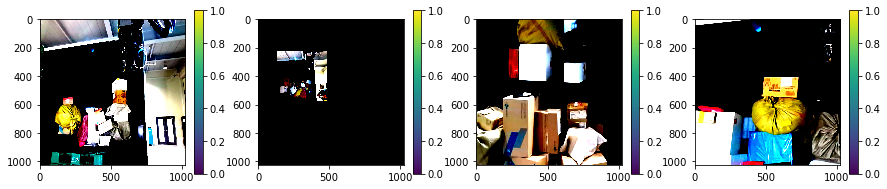

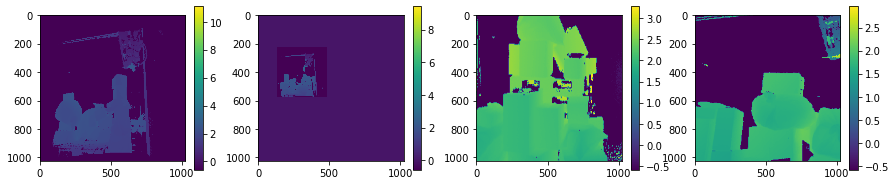

In [5]:


dataset = COCODetection(
    color_img_path=cfg.dataset.train_color_images,
    depth_img_path=cfg.dataset.train_depth_images,
    info_file=cfg.dataset.train_info,
    transform=SSDAugmentation(mean=cfg.dataset.mean, std=cfg.dataset.std),
)

# if args.validation_epoch > 0:
#     setup_eval()
#     val_dataset = COCODetection(
#         color_img_path=cfg.dataset.valid_color_images,
#         depth_img_path=cfg.dataset.valid_depth_images,
#         info_file=cfg.dataset.valid_info,
#         transform=BaseTransform(mean=cfg.dataset.mean, std=cfg.dataset.std),
#     )

data_loader = data.DataLoader(dataset, 1,
                              num_workers=1,
                              shuffle=True, collate_fn=detection_collate,
                              pin_memory=True)

color_lists = []
depth_lists = []
i = 0 

for datum in data_loader:
    print((datum[0][0][0]).shape)
    color_lists.append(datum[0][0][0].permute(1, 2, 0).reshape(1024, 1024,3))
    depth_lists.append(datum[0][1][0].permute(1, 2, 0).reshape(1024, 1024))
    # imgplot = plt.imshow(datum[0][1][0].permute(1, 2, 0))

    i += 1

    if(i > 3):
        break

plot(*color_lists)
plot(*depth_lists)

13685


True

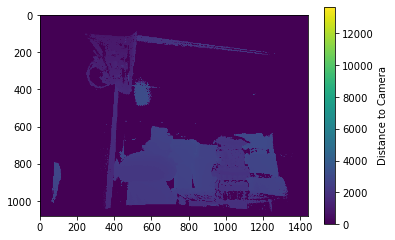

In [6]:
import cv2

depth_img = cv2.imread('/home/plaif/Downloads/unloader_rgbd_20210930/unloader_rgbd/depth/000630.png', cv2.IMREAD_UNCHANGED)
plt.imshow(depth_img)
print(depth_img.max())
plt.colorbar(label='Distance to Camera')

depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_img, alpha=0.03), cv2.COLORMAP_JET)
cv2.imwrite("depth_img2.png", depth_colormap)


12492.0


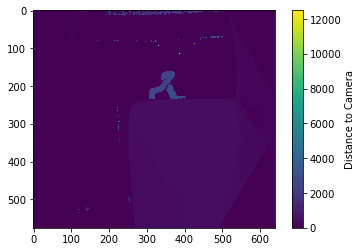

In [7]:
np_depth = np.load('/home/plaif/Documents/repo/yolact/depth_img.npy')

np_depth.max()

plt.imshow(np_depth)
print(np_depth.max())
plt.colorbar(label='Distance to Camera')